In [1]:
import sys
import time
import math
import numpy as np
import numpy.ma as ma
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.insert(1, '../src/')
import os.path
import kde as kde
import scms as scms
from fastkde import fastKDE

In [2]:
data = np.loadtxt('P.0500.ascii', unpack=True, skiprows=1)
R = np.sqrt(data[1,:] ** 2 + data[2,:] ** 2)
z = data[3,:]
vz = data[6,:]
vR = (data[1,:] * data[4,:] + data[2,:] * data[5,:]) / R
vp = (data[1,:] * data[5,:] - data[2,:] * data[4,:]) / R
Lz = vp * R

In [3]:
points = np.vstack([z, vz]).T

In [4]:
def plot_2d_histogram(x, y, bins=100, filename="test.png", title=""):
    hist, xe, ye = np.histogram2d(x,y,bins=bins)
    fig = plt.pcolormesh(xe,ye,hist.T,cmap='RdPu')
    plt.xlabel("$z$")
    plt.ylabel("$v_z$")
    plt.xlim((-1.5, 1.5))
    plt.ylim((-0.8, 0.8))
    plt.title(title)
    plt.colorbar()
#     plt.savefig(filename, dpi=300)
    plt.show()

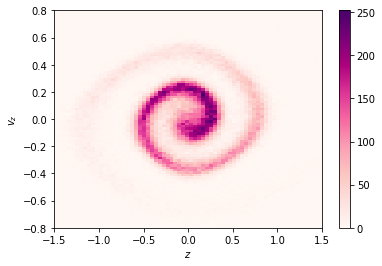

In [5]:
plot_2d_histogram(points[:,0], points[:,1], bins=100)

In [6]:
data = np.loadtxt('U.0500.ascii', unpack=True, skiprows=1)
R = np.sqrt(data[1,:] ** 2 + data[2,:] ** 2)
z = data[3,:]
vz = data[6,:]
vR = (data[1,:] * data[4,:] + data[2,:] * data[5,:]) / R
vp = (data[1,:] * data[5,:] - data[2,:] * data[4,:]) / R
Lz = vp * R
bg_points = np.vstack([z, vz]).T[:200000]

ratio = points.shape[0] / bg_points.shape[0]
# ratio = 'N/A'
print("Spiral2Background Ratio: {}".format(ratio))

Spiral2Background Ratio: 0.50075


In [7]:
points = np.concatenate([points, bg_points])

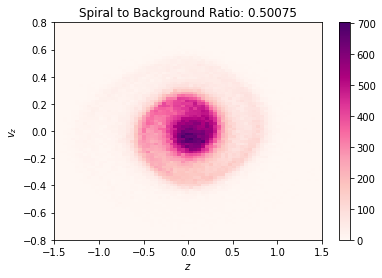

In [8]:
plot_2d_histogram(points[:,0], points[:,1], title="Spiral to Background Ratio: {}".format(ratio))

In [8]:
def NormV(vec):
    norm = np.linalg.norm(vec)
    if (norm == 0):
        return vec
    return vec/norm

#Pass in array H = [[fxx,fxy],[fyx,fyy]]/ Where these are evaluated at some
#position
#VM is a matrix that is meant to convert the MeanShift Vector
#This should be working for any number of dimensions
#Hessian- Matrix evaluated at X.
# m is number of dimensions to remove
def SpectralDecomp(Hessian,m):
    EVal, EVec = np.linalg.eigh(Hessian)
    for i in range(m):
        I = np.argmin(EVal)
        EVec = np.delete(EVec,I,0)
        EVal = np.delete(EVal,I,0)
    V = EVec
    VT = V.T
    VM = np.matmul(VT,V)
    return VM

In [9]:
#Returns the derivatives and the Hessian Matrix
def gradients2(f):
    #The numeric first derivatives evaluated on same grid as above
    Gx=np.gradient(f,axis = 0)
    Gy=np.gradient(f,axis = 1)
    #The second derivatives for the Hessian
    Gxx=np.gradient(Gx,axis = 0)
    Gxy=np.gradient(Gx,axis = 1)
    Gyy=np.gradient(Gy,axis = 1)
    Gyx=np.gradient(Gy,axis = 0)
    return np.array(Gx), np.array(Gy), np.array([[Gxx, Gxy],[Gyx, Gyy]])

#Bilinear interpolation
def BInterp(Xp,Yp,gx,gy,F):
    #What to do if at the very edge
    maxN = len(gx)
    if((Xp < gx[0]) or (Xp>= gx[-1])):
        #print('Out of Bounds')
        return 0
    if((Yp < gy[0]) or (Yp >= gy[-1])):
        return 0
    Nx = np.int((Xp-gx[0])/(gx[1]-gx[0]))
    Ny = np.int((Yp-gy[0])/(gy[1]-gy[0]))
    FQ11 = F[Nx,Ny]
    FQ12 = F[Nx,Ny+1]
    FQ22 = F[Nx+1,Ny+1]
    FQ21 = F[Nx+1,Ny]
    dX = gx[Nx+1]-gx[Nx]
    F1a = (gx[Nx+1]-Xp)/(dX)*FQ11
    F1b = (Xp-gx[Nx])/(dX)*FQ21
    F2a = (gx[Nx+1]-Xp)/dX*FQ12
    F2b = (Xp-gx[Nx])/dX*FQ22
    dY = gy[Ny+1]-gy[Ny]
    FI = (gy[Ny+1]-Yp)/dY*(F1a+F1b) + (Yp-gy[Ny])/dY*(F2a+F2b)
    return FI

#Apply Bi-Linear Interpolation to Hessian
def InterpHess2(zi,wi,ze,we,GHessian):
    size = np.shape(GHessian)
    dim = size[0]
    Hessian = np.zeros([dim,dim])
    for i in range(dim):
        for j in range(dim):
            Gij = GHessian[i,j,:,:]
            Gijp = BInterp(zi,wi,ze,we,Gij)
            Hessian[i,j] = Gijp
    return Hessian

#The Subspace Constrained Mean Shift Vector
def meanShift_2D(Xp,Yp,gx,gy,Gx,Gy,GH):
    Px = BInterp(Xp,Yp,gx,gy,Gx)
    Py = BInterp(Xp,Yp,gx,gy,Gy)
    MS = np.array([Px,Py])
    MS = NormV(MS)
    #Hessian Calculations
    Hessian = InterpHess2(Xp,Yp,gx,gy,GH)
    #Change to 0? What happens
    VM = SpectralDecomp(Hessian,1)
    MC = np.matmul(VM,MS)
    MC = NormV(MC)
    return MC

#Using Cash-Karp Parameters for Embedded Runga-Kutta Method
#(Xp,Yp) - The point
#(Gx,Gy,GH) - The derivatives along each direction and the Hessian
#gx,gy - The linear grid axes for the interpolation
#dh - The step size
def RFA_EmbeddedRK_2D(Xp,Yp,Gx,Gy,GH,gx,gy,dh):
    P = [Xp,Yp]
    MC = meanShift_2D(Xp,Yp,gx,gy,Gx,Gy,GH)
    #First Step
    k1 = dh*MC
    #Step 2
    Pt = P+k1/5
    MC = meanShift_2D(Pt[0],Pt[1],gx,gy,Gx,Gy,GH)
    k2 = dh*MC
    #Step 3
    Pt = P+k1*3./40+k2*9./40
    MC = meanShift_2D(Pt[0],Pt[1],gx,gy,Gx,Gy,GH)
    k3 = dh*MC
    #Step 4
    Pt = P+k1*3./10+k2*(-9./10)+k3*6./5
    MC = meanShift_2D(Pt[0],Pt[1],gx,gy,Gx,Gy,GH)
    k4 = dh*MC
    #Step 5
    Pt = P+k1*(-11./54)+k2*5./2+k3*(-70/27)+k4*35./27
    MC = meanShift_2D(Pt[0],Pt[1],gx,gy,Gx,Gy,GH)
    k5 = dh*MC
    #Step 6
    Pt = P+k1*(1631./55296)+k2*(175./512)+k3*(575./13824)+k4*(44275./110592)+k5*(253./4096)
    MC = meanShift_2D(Pt[0],Pt[1],gx,gy,Gx,Gy,GH)
    k6 = dh*MC
    #Fifth-order Runge-Kutta formula
    Pt2 = P+k1*37/378+k3*250./621+k4*125./594+k6*512./1771
    
    #Embedded fourth-order Runge-Kutta formula
    Pt1 = P+k1*2825./27648+k3*18575./48384+k4*13525./55296+k5*277./14336+k6*1./4

    return Pt1[0],Pt1[1],Pt2[0],Pt2[1]

#f - evaluted on gx,gy grid
#dataset is any [d,n] array of points. 
def RFA_AdaptiveStep_Lin_ERK_2D(dataset,f,gx,gy,tcap):
    size = np.shape(dataset)
    Xn = ma.zeros(size[1])
    Yn = ma.zeros(size[1])
    #Each point starts with a default step size
    H = np.zeros(size[1])+0.05
    Xn = dataset[0,:]
    Yn = dataset[1,:]
    
    plt.plot(Xn, Yn, 'k.', markersize=0.3)
    plt.xlabel("$z$")
    plt.ylabel("$v_z$")
    # plt.savefig("test3.png", dpi=300)
    plt.show()

    #The accuracy tolerance
    dx0 = 0.000001
    dy0 = 0.000001
    #Gradient+Hessian
    Gx,Gy,GH = gradients2(f)
    #Iterate through, SCMS algorithm
    for t in range(tcap):
        for i in range(size[1]):
            Xp = Xn[i]
            Yp = Yn[i]
            if(ma.is_masked(Xp) or ma.is_masked(Yp)):
                continue
            if(abs(Xp) >= 100.):
                continue
            if(abs(Yp) >= 100):
                continue
            h = H[i] #Each point has its own error
            #Embedded Runge-Kutta
            x1,y1,x2,y2 = RFA_EmbeddedRK_2D(Xp,Yp,Gx,Gy,GH,gx,gy,h)
            dx1 = abs(x2-x1)
            if(dx1 == 0):
                modx = 2
            else:
                modx = (dx0/dx1)**(0.2)
                if(modx > 2):
                    modx = 2
            dy1 = abs(y2-y1)
            if(dy1 ==0):
                mody = 2
            else:
                mody = (dy0/dy1)**(0.2)
                if(mody > 2):
                    mody = 2
            #Choose the smaller of the two
            if(modx < mody):
                mod = modx
            else:
                mod = mody
            if(mod < 1): #d1 > d0, we have to retry! with new step
                h = h*mod
                x1,y1,x2,y2 = RFA_EmbeddedRK_2D(Xp,Yp,Gx,Gy,GH,gx,gy,h)
                H[i] = h #update the new h value
                Xn[i] = x2
                Yn[i] = y2
            else: #We can safely increase the next step size
                H[i] = h*mod
                Xn[i] = x2 #the small step we already calculated was good enough
                Yn[i] = y2 
        print(t)
    return Xn,Yn,H


In [19]:
myPDF,axes = fastKDE.pdf(points[:,0],points[:,1])

# d = 2
# A0 = 1
# bw = A0 * min(np.std(points[:,0]), np.std(points[:,1])) * 1 / (
#     d + 2) ** (1 / (d + 4)) / points.shape[0] ** (1 / (d + 4))
# print("BW =", bw)
# bound = 256 * bw / 2
# v1, v2 = np.linspace(-bound,bound,256), np.linspace(-bound,bound,256)
# myPDF = kde.kde2(points, v1, v2, bandwidth=bw).T

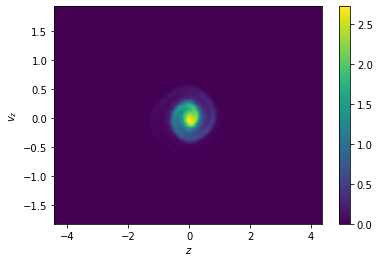

(257, 257)


In [20]:
plt.pcolormesh(axes[0], axes[1], myPDF)
plt.colorbar()
# plt.title("Spiral to Background Ratio: {}".format(ratio))
plt.xlabel("$z$")
plt.ylabel("$v_z$")
# plt.savefig("s2n0p125_kde.png", dpi=300)
plt.show()
print(myPDF.shape)

In [21]:
v1,v2 = axes
zg,wg = np.meshgrid(v1,v2,indexing='ij')
zg_ma = ma.masked_where(myPDF < np.std(myPDF),zg)
zg = None
wg_ma = ma.masked_where(myPDF < np.std(myPDF),wg)
wg = None
T = zg_ma.compressed()
newS = len(T)
P1_ma = ma.zeros((2,newS))
P1_ma[0,:] = zg_ma.compressed()
P1_ma[1,:] = wg_ma.compressed()

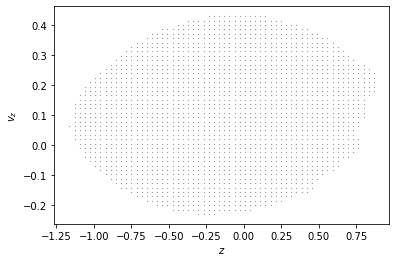

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [22]:
X1,Y1,H1 = RFA_AdaptiveStep_Lin_ERK_2D(P1_ma,myPDF,v1,v2,20)

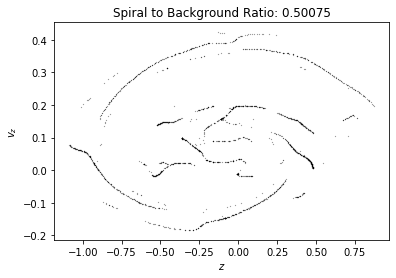

In [23]:
plt.plot(X1, Y1, 'k.', markersize=0.3)
plt.title("Spiral to Background Ratio: {}".format(ratio))
plt.xlabel("$z$")
plt.ylabel("$v_z$")
# plt.savefig("test3.png", dpi=300)
plt.show()

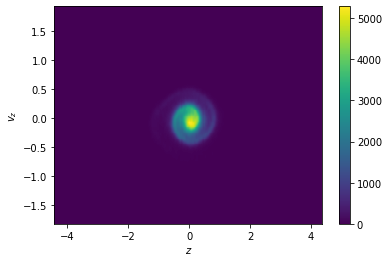

In [31]:
myPDF = kde.kde2(points, v1, v2, bandwidth=0.025)
plt.pcolormesh(v1, v2, myPDF)
plt.colorbar()
# plt.title("Spiral to Background Ratio: {}".format(ratio))
plt.xlabel("$z$")
plt.ylabel("$v_z$")
# plt.savefig("s2n0p125_kde.png", dpi=300)
plt.show()

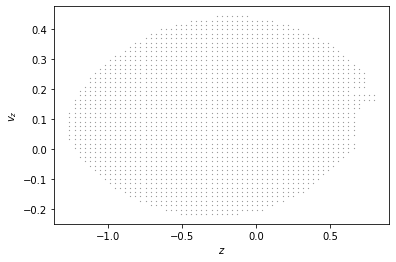

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [32]:
zg,wg = np.meshgrid(v1,v2,indexing='ij')
zg_ma = ma.masked_where(myPDF < np.std(myPDF),zg)
zg = None
wg_ma = ma.masked_where(myPDF < np.std(myPDF),wg)
wg = None
T = zg_ma.compressed()
newS = len(T)
P1_ma = ma.zeros((2,newS))
P1_ma[0,:] = zg_ma.compressed()
P1_ma[1,:] = wg_ma.compressed()
X1,Y1,H1 = RFA_AdaptiveStep_Lin_ERK_2D(P1_ma,myPDF,v1,v2,20)

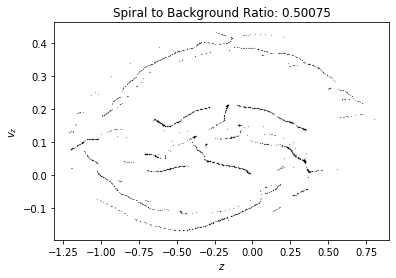

In [33]:
plt.plot(X1, Y1, 'k.', markersize=0.3)
plt.title("Spiral to Background Ratio: {}".format(ratio))
plt.xlabel("$z$")
plt.ylabel("$v_z$")
# plt.savefig("test3.png", dpi=300)
plt.show()